# Projection of CO2 Emissions from Electricity Production in the US Utilizing ARIMA Modeling

Forecasting future changes in climate is a very complicated task and requires a wide breadth of information to even come close to an accurate prediction of future changes.  However,  there are some major influencers that are useful for providing rough estimations of future increases or decreases in the global temperature.  Of these, one of the most effective is greenhouse gasses, which cause light to be trapped in the atmosphere longer due to the way in which they scatter light.  This means that increased levels of greenhouse gasses cause more energy  to be transferred to the Earths atmosphere throughout the 'random walk' of incoming photons from the sun, since the increased presence of these gasses cause light to stay in the atmosphere longer. This is why being able to forecast future increases or decreases in greenhouse gasses such as methane (CH4), carbon dioxide (CO2), water vapor (H2O), and nirous oxide (N2O) is a vital part of being able to accurately predict future changes in the Earths temperature.  That is why for this project I attempted to model the trends in CO2 emissions from a wide range of sources using ARIMA modeling in order to determine if this type of model could be used to help in identifying future climate trends.  

# Data Used
For this project the dataset I selected is the [carbon emissions dataset](https://www.kaggle.com/txtrouble/carbon-emissions/metadata) which contains data corresponding to the monthly and annual CO2 emissions from electricity generation, which was aquired from the US Energy Information Administration and contains data from 1973-2016.  The data is broken down by fuel type and the values below correspond to million metric tons of CO2.  


In [26]:
import scipy
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import statsmodels and required packages
import statsmodels as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

# Remove warnings to make final notebook look cleaner
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Read in data
df = pd.read_csv('C:\\Users\halln\Desktop\THINKFUL\Datasets\CO2_emission_prediction\emissions.csv')

# Convert to Datetime format
df['Date'] = df['YYYYMM'].apply(lambda x: pd.to_datetime(x, format='%Y%m',errors='coerce'))
# Remove NaT values
df['NaT'] = df['Date'].apply(lambda x: str(x))
df = df[df['NaT']!='NaT']
df = df.drop(columns='NaT')

# Remove entries that are 'Not Available'
df = df[df['Value']!='Not Available']
# Convert data to float 
df['Value'] = df['Value'].apply(lambda x: pd.to_numeric(x))

# Index data with dates
data = pd.DataFrame(index=df['Date'])
data['Value'] = list(df['Value'])
data['Description'] = list(df['Description'])

# Print first 10 rows of data
data.head(n=10)

,Value,Description
Date,,
1973-01-01,72.076,Coal Electric Power Sector CO2 Emissions
1973-02-01,64.442,Coal Electric Power Sector CO2 Emissions
1973-03-01,64.084,Coal Electric Power Sector CO2 Emissions
1973-04-01,60.842,Coal Electric Power Sector CO2 Emissions
1973-05-01,61.798,Coal Electric Power Sector CO2 Emissions
1973-06-01,66.538,Coal Electric Power Sector CO2 Emissions
1973-07-01,72.626,Coal Electric Power Sector CO2 Emissions
1973-08-01,75.181,Coal Electric Power Sector CO2 Emissions
1973-09-01,68.397,Coal Electric Power Sector CO2 Emissions


In [49]:
# Show biggest contributiors to CO2 output
sources = data.groupby('Description').sum()
bar = sources.sort_values(by='Value',ascending=False)
print(bar)

                                                        Value
Description                                                  
Total Energy Electric Power Sector CO2 Emissions    82352.676
Coal Electric Power Sector CO2 Emissions            65782.393
Natural Gas Electric Power Sector CO2 Emissions     11295.359
Petroleum Electric Power Sector CO2 Emissions        4982.993
Residual Fuel Oil Electric Power Sector CO2 Emi...   4239.312
Distillate Fuel, Including Kerosene-Type Jet Fu...    404.887
Petroleum Coke Electric Power Sector CO2 Emissions    338.785
Non-Biomass Waste Electric Power Sector CO2 Emi...    281.367
Geothermal Energy Electric Power Sector CO2 Emi...     10.563


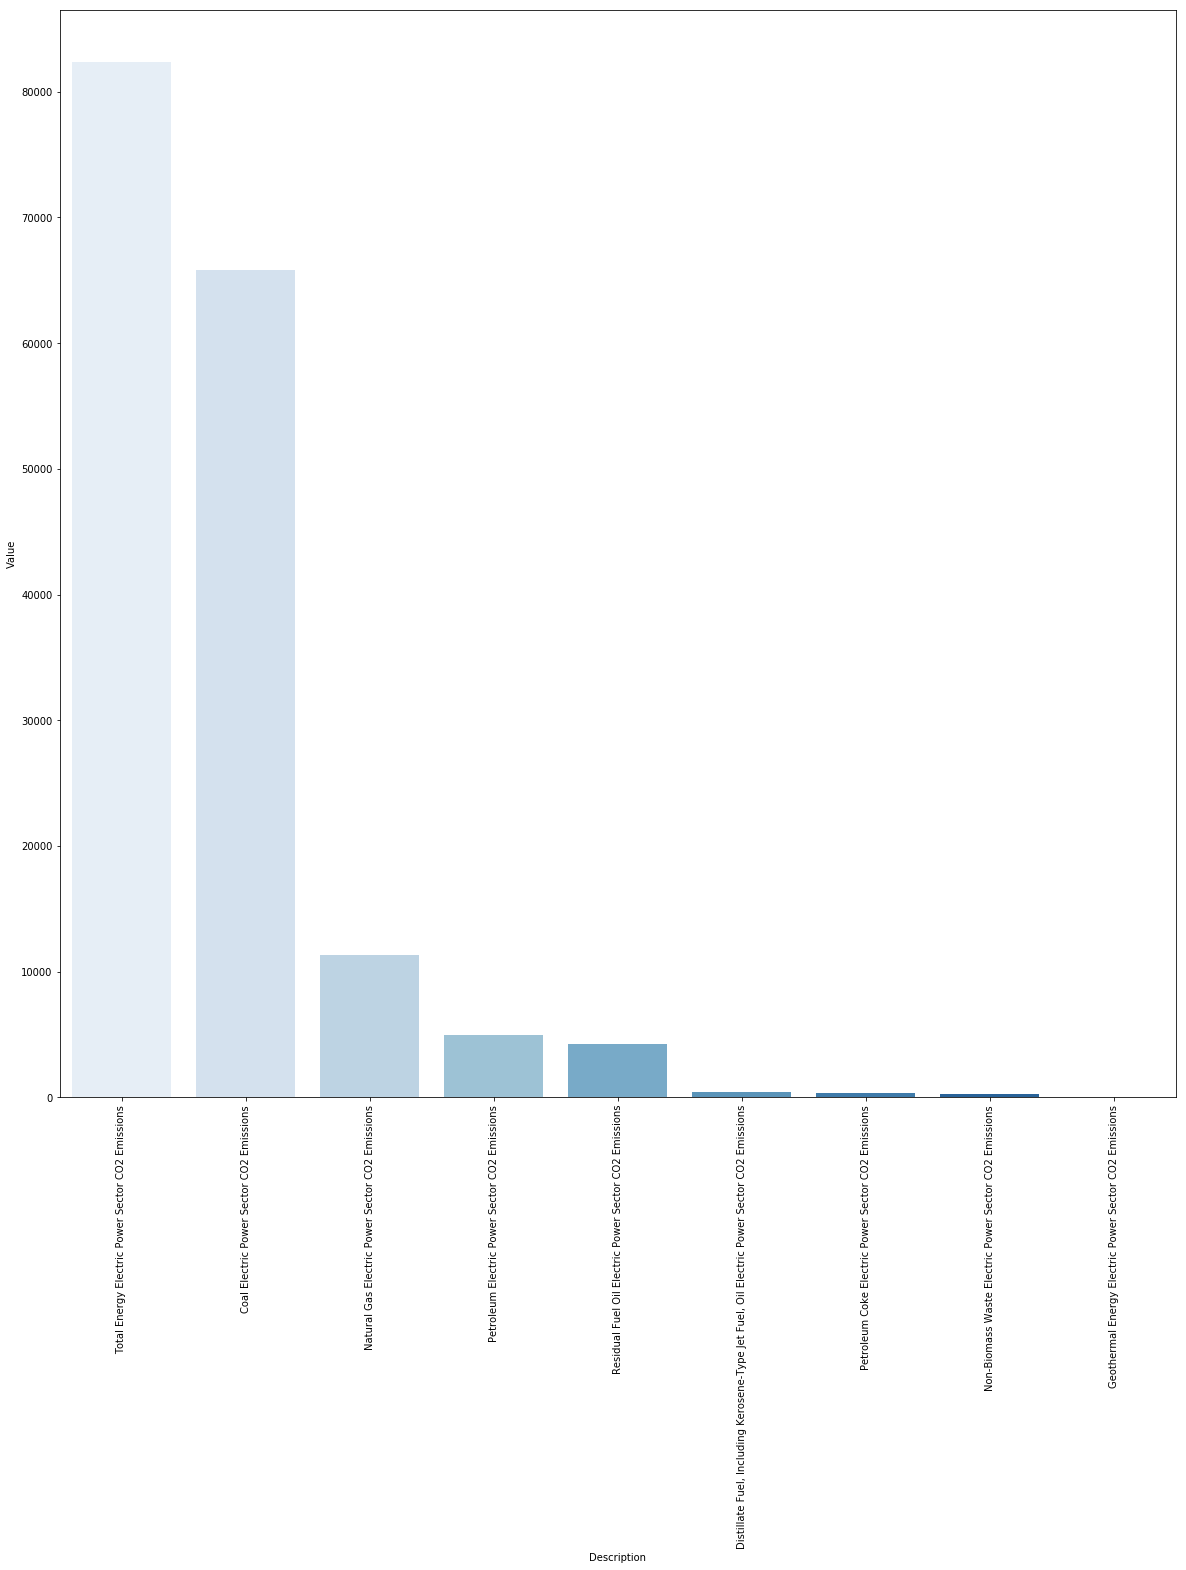

In [50]:
# Create barplot showing biggest contributors to CO2 output
plt.figure(figsize=(20,20))
sns.barplot(y='Value',x=bar.index,data=bar,palette='Blues')
plt.xticks(rotation='vertical')
plt.show()

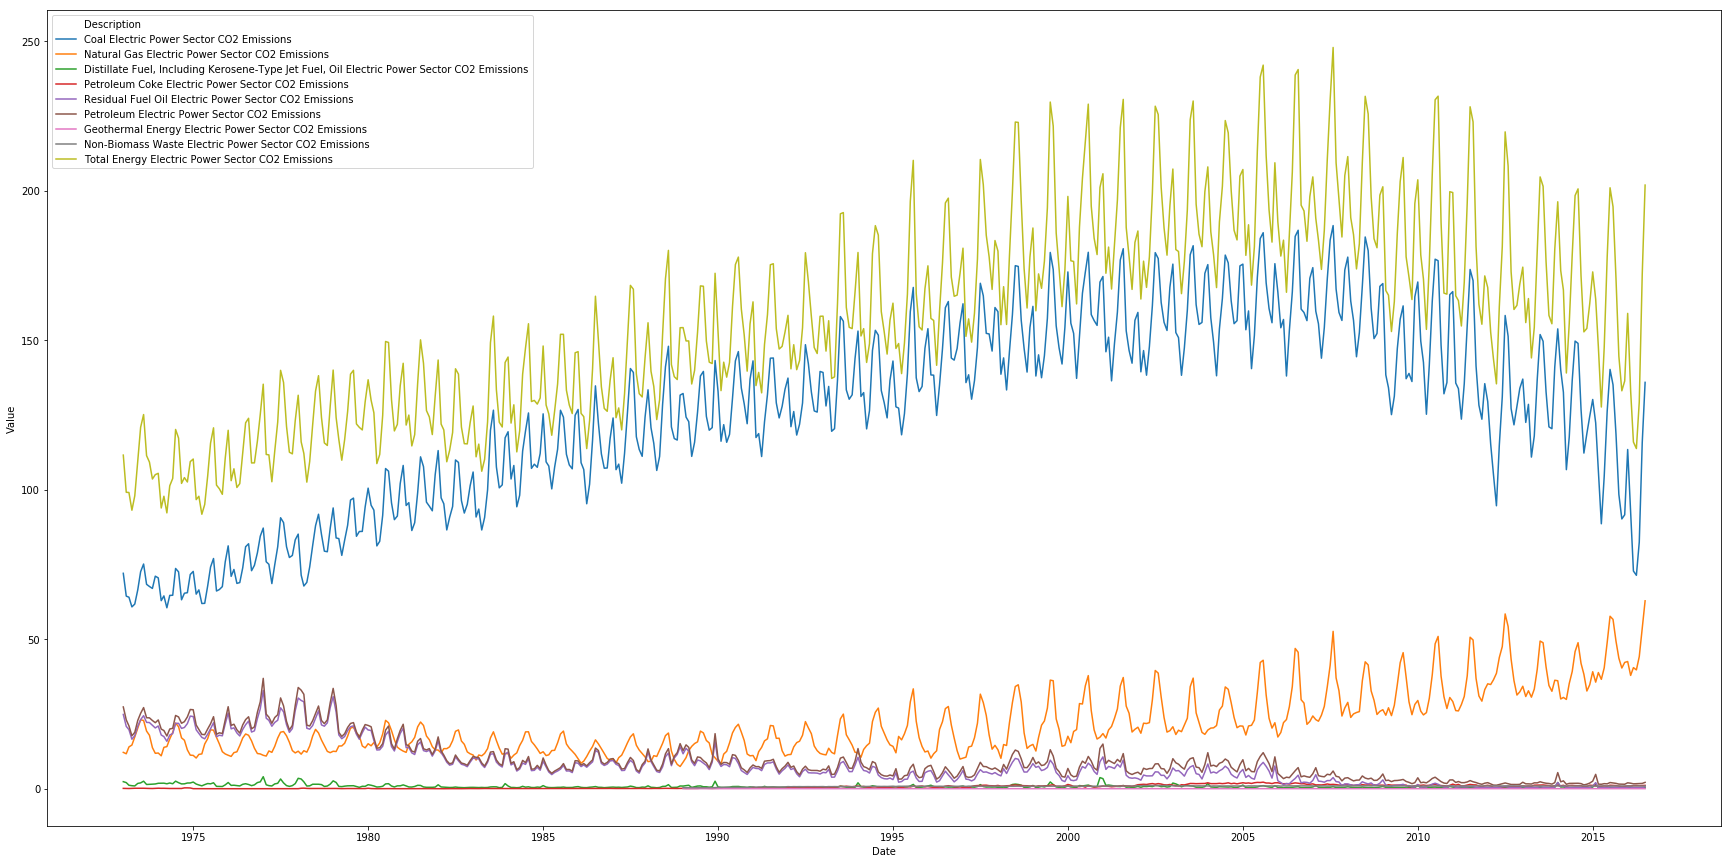

In [29]:
# Plot trend in CO2 output by source over time
plt.figure(figsize=(30,15))
sns.lineplot(data=data, x=data.index,y='Value',hue='Description')

As can be seen by the plots above, the largest contributor to the total electric CO2 output is coal electric power, and the trend in total electric CO2 output matches the trend from this most closely.  For this project I will try to model the total electric CO2 output along with the trends in the top 3 contributors to the total electric CO2 output

In [30]:
# Collect total electric energy CO2 emissions along with top 3 contributors into seperate variables
te = data[data['Description']=='Total Energy Electric Power Sector CO2 Emissions']
ce = data[data['Description']=='Coal Electric Power Sector CO2 Emissions']
ng = data[data['Description']=='Natural Gas Electric Power Sector CO2 Emissions']
pe = data[data['Description']=='Petroleum Electric Power Sector CO2 Emissions']


In [41]:
# DEFINE FUNCTIONS TO BE USED THROUGHOUT NOTEBOOK 

# Define function to test stationarity of time series
def test_stationarity(timeseries):    
# Determing rolling statistics for timeseries
    rolmean = timeseries.rolling(center=False,window=12).mean()
    rolstd = timeseries.rolling(center=False,window=12).std()
# Plot rolling statistics alongside data
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Time Series')
    plt.show(block=False)    
# Create ACF Plot of timeseries
    plot_acf(timeseries.dropna(inplace=False))
    plt.xlim(0,25)
    plt.title("ACF Plot")
    plt.show()   
# Create PACF Plot of timeseries
    x_pacf = pd.DataFrame(pacf(timeseries.dropna(inplace=False)))
    x_pacf.plot(kind='bar')
    plt.title("PACF Plot")
    plt.show()
#Perform Dickey-Fuller test and print results
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    output = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    
    
    
# Define function to generate predictions for each arima order
def evaluate_arima(train, test, arima_order):
# Populate history based on training set
    history = [x for x in train]
# Create blank list of predictions to populate
    predictions = list()
# Use rolling forward walk predictions.  Fit model using history,
# adding each prediction to history to continue forecasting
    for i in range(len(test)):
    # Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
    # Get prediction
        y_pred = model_fit.forecast()[0]
    # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)
    # Append to history to continue to rolling forecast 
        history.append(y_pred)
    error = mean_squared_error(test, predictions)
    return error



# Define function to determine best arima specifications based on MSE
def arima_gridsearch(train, test, p_vals, d_vals, q_vals):
# Create blank variables to store parameters in
    best_score = float('inf') 
    best_config = None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                arima_order = (p, d, q)
# Evaluate arima model with each combination of specifications 
# and append best results to list
                try:
                    mse = evaluate_arima(train, test, arima_order)
                    if mse < best_score:
                        best_score, best_config = mse, arima_order
                    print('ARIMA Parameters: {}   Resulting MSE:{}'.format(arima_order, mse))
                except (ValueError, np.linalg.LinAlgError): # ignore non converging errors
                    pass
    print('Best ARIMA config:', best_config)
    print('MSE:', best_score)
    
    
    
# Function to plot predictions from models given arima parameters p,d,q
def plot_predictions(title,train, test, p, d, q):
    arima_order = (p,d,q)
    history = [x for x in train]
# Blank list to store predictions in
    predictions = list()
# Run model for multiple sets of parameters and append results
    for i in range(len(test)):
# Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
# Forcast predicted results
        y_pred = model_fit.forecast()[0]
# Append forecasts to list
        predictions.append(y_pred)
# Append to history to continue to rolling forecast 
        history.append(y_pred)
# Create plots
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('{}'.format(str(title)))
    plt.legend()

# Define function to plot residuals of model
def plot_model_residuals(title, train, p, d, q):
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit()
    residuals = model_fit.resid
# Create line plot of residuals
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('{}'.format(str(title)))
    residuals.plot()
# Create Histogram of residuals
    plt.subplot(1,2,2)
    residuals.hist(bins=25)
    plt.title('{}'.format(str(title)))
    plt.show()
    plt.figure(figsize=(5,5))
    scipy.stats.probplot(x=residuals,fit=True,plot=plt)
    plt.title("PP Plot of Residuals")
    plt.show()

# Model Building for Total Electric CO2 Output

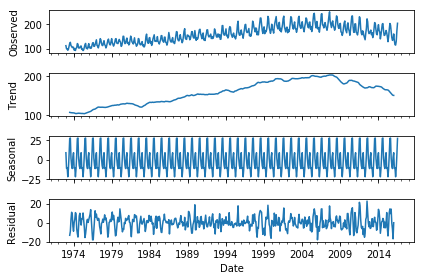

In [8]:
# Decompose data to show overall trend in data - data appears to be seasonally dependent
decomp = seasonal_decompose(te.Value,model='additive')
decomp.plot()
plt.show()

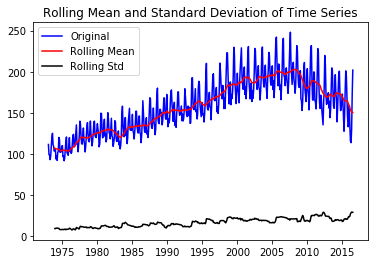

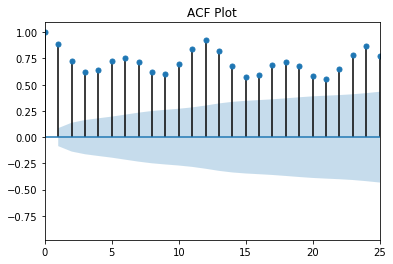

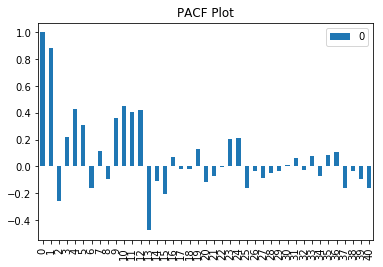

Results of Dickey-Fuller Test:
ADF Test Statistic              -1.809627
p-value                          0.375693
Number of Lags Used             14.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64


In [9]:
# Test Stationarity of Total Electric CO2 Output
test_stationarity(te.Value)

In [10]:
# Lets try shifting the data in a number of different ways to make data stationary
te['Log_Difference'] = np.log(te.Value).diff()
te['Seasonal_Difference'] = te.Value - te.Value.shift(12)
te['Shift_1'] = te.Value - te.Value.shift(1)

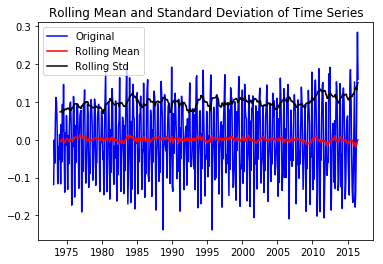

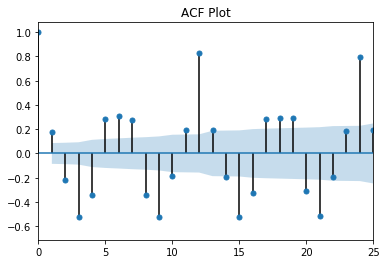

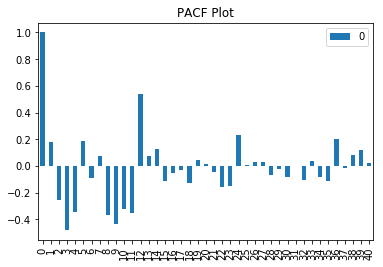

Results of Dickey-Fuller Test:
ADF Test Statistic            -6.487986e+00
p-value                        1.246987e-08
Number of Lags Used            1.300000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64


In [11]:
test_stationarity(te.Log_Difference.dropna(inplace=False))

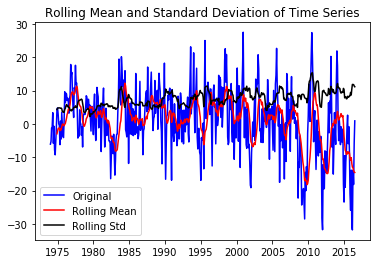

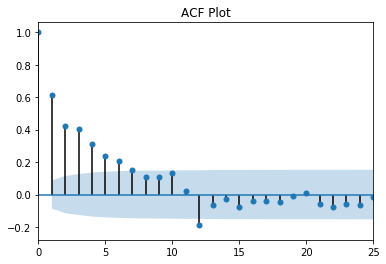

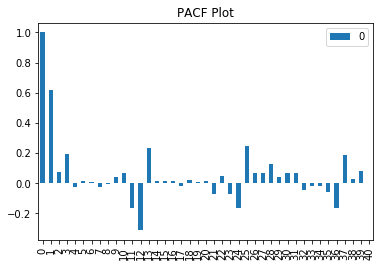

Results of Dickey-Fuller Test:
ADF Test Statistic              -5.495918
p-value                          0.000002
Number of Lags Used             12.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64


In [12]:
test_stationarity(te.Seasonal_Difference.dropna(inplace=False))

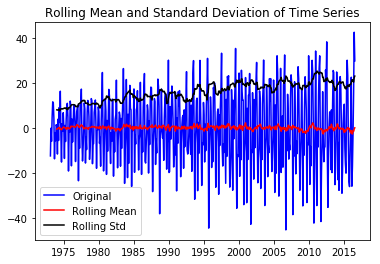

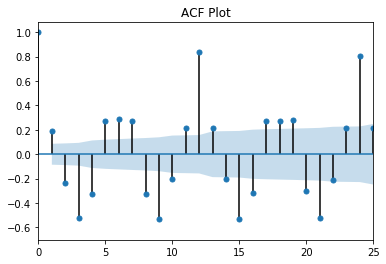

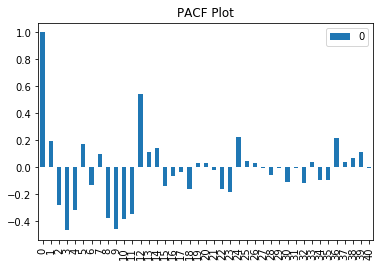

Results of Dickey-Fuller Test:
ADF Test Statistic            -6.610275e+00
p-value                        6.402884e-09
Number of Lags Used            1.300000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64


In [13]:
test_stationarity(te.Shift_1.dropna(inplace=False))

In [14]:
# Data definitely appears to be seasonally dependent but this doesent capture the full trend, lets try log shifting the seasonally shifted data
te['Seas_Log_Diff'] = np.log(te.Seasonal_Difference).diff()

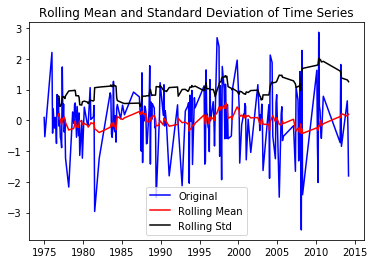

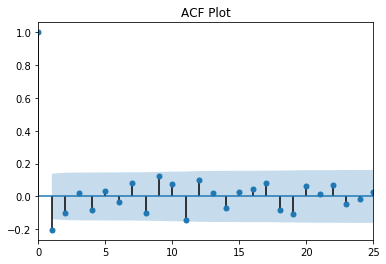

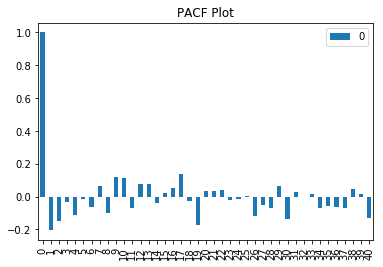

Results of Dickey-Fuller Test:
ADF Test Statistic            -1.256094e+01
p-value                        2.103280e-23
Number of Lags Used            1.000000e+00
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


In [15]:
test_stationarity(te.Seas_Log_Diff.dropna(inplace=False))

In [15]:
# Split into test and training data for model, using dates later than 2010 to test the data

# Take just total energy data
te = data[data['Description']=='Total Energy Electric Power Sector CO2 Emissions']

# Split into training and test set
te_train = te[te.index < '2010-01-01']
te_test = te[te.index >= '2010-01-01']

In [85]:
# Do Gridsearch to find best arima parameters for raw data - forced to use smaller parameters due to runtime constraints on computer (see bottom of notebook)
arima_gridsearch(te_train.Value.dropna(inplace=False),te_test.Value.dropna(inplace=False), range(5),range(5),range(3))

ARIMA Parameters: (0, 0, 0)   Resulting MSE:923.1188965168923
ARIMA Parameters: (0, 0, 1)   Resulting MSE:893.4768421403121
ARIMA Parameters: (0, 1, 0)   Resulting MSE:1817.454393223415
ARIMA Parameters: (0, 1, 1)   Resulting MSE:2280.7662881996616
ARIMA Parameters: (0, 1, 2)   Resulting MSE:2104.4163185948246
ARIMA Parameters: (0, 2, 0)   Resulting MSE:2714219.1283221478
ARIMA Parameters: (0, 2, 1)   Resulting MSE:1745.3196453149526
ARIMA Parameters: (0, 2, 2)   Resulting MSE:2448.6681511019133
ARIMA Parameters: (1, 0, 0)   Resulting MSE:727.0527522063767
ARIMA Parameters: (1, 0, 1)   Resulting MSE:763.4718293819994
ARIMA Parameters: (1, 0, 2)   Resulting MSE:920.969258032912
ARIMA Parameters: (1, 1, 0)   Resulting MSE:2198.5888945905713
ARIMA Parameters: (1, 1, 1)   Resulting MSE:2871.355982266053
ARIMA Parameters: (1, 1, 2)   Resulting MSE:2898.3498476005775
ARIMA Parameters: (1, 2, 0)   Resulting MSE:1435721.0615128975
ARIMA Parameters: (2, 0, 0)   Resulting MSE:772.2945834212047
A

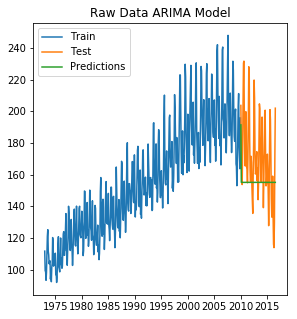

In [9]:
plot_predictions('Raw Data ARIMA Model',te_train.Value,te_test.Value,0,0,1)

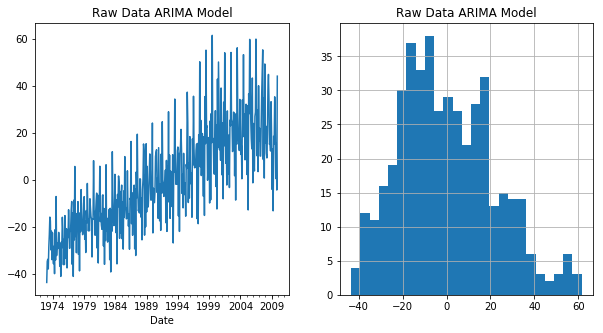

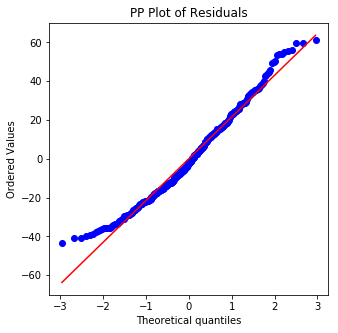

In [42]:
plot_model_residuals('Raw Data ARIMA Model',te_train.Value,0,0,1)

Although the residuals appear to be fairly normal, this model produced a poor fit for the data, not really capturing any of the aspects of the trends seen in the real data.  However, this is most likely due to computational constraints (this machine is not powerful enough to truly incorporate the seasonality in an efficient and effective way without running the models for potentially weeks).  Furthermore,  the data for the total electric CO2 output is influenced by trends present in all types of CO2 output from every energy sector in the US meaning that the data is very noisy and contains many different types of differing trends working together to produce the data seen above.  Next I will try modeling the top 3 contributors to total electric CO2 output to see if the models will better be able to capture the trends present in the slightly less noisy data.  The first contributor I will try to model is coal electric CO2 output, which follows a very simmilar trend to the total electric CO2 output so I anticipate simmilar results.

# Model Building for Coal Electric CO2 Output

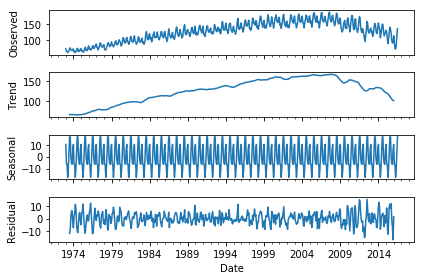

In [10]:
# Decompose data to show overall trend in data - data appears to be very seasonally dependent and very simmilar to total electric data
decomp = seasonal_decompose(ce.Value,model='additive')
decomp.plot()
plt.show()

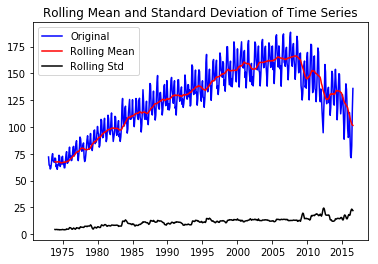

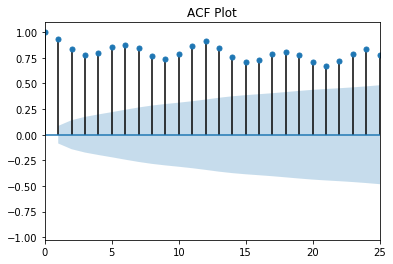

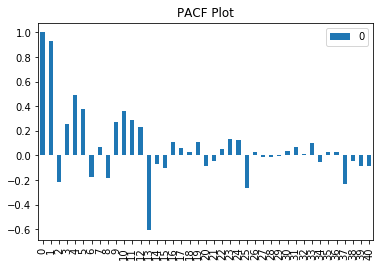

Results of Dickey-Fuller Test:
ADF Test Statistic              -1.827631
p-value                          0.366833
Number of Lags Used             14.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64


In [12]:
# Test Stationarity of Total Coal CO2 Output
test_stationarity(ce.Value)

In [13]:
# Lets try shifting the data in a number of different ways to make data stationary
ce['Log_Difference'] = np.log(ce.Value).diff()
ce['Seasonal_Difference'] = ce.Value - ce.Value.shift(12)
ce['Shift_1'] = te.Value - ce.Value.shift(1)

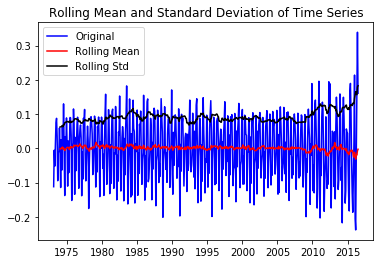

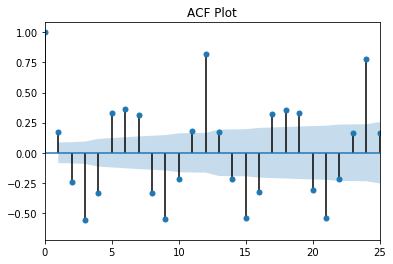

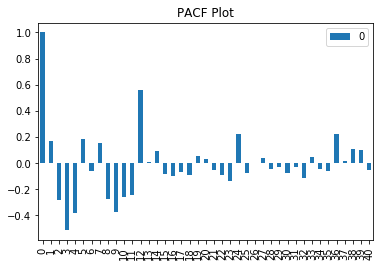

Results of Dickey-Fuller Test:
ADF Test Statistic              -5.111562
p-value                          0.000013
Number of Lags Used             13.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64


In [14]:
test_stationarity(ce.Log_Difference.dropna(inplace=False))

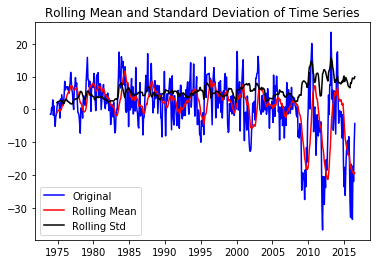

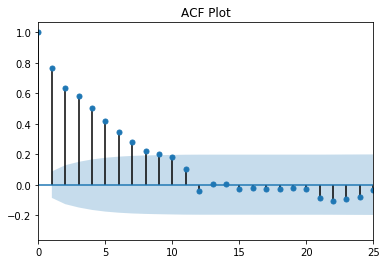

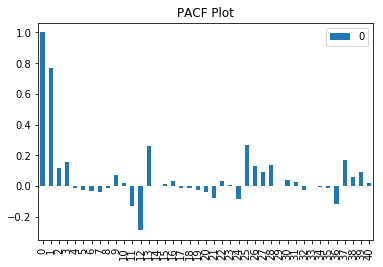

Results of Dickey-Fuller Test:
ADF Test Statistic              -4.736434
p-value                          0.000072
Number of Lags Used             12.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64


In [15]:
test_stationarity(ce.Seasonal_Difference.dropna(inplace=False))

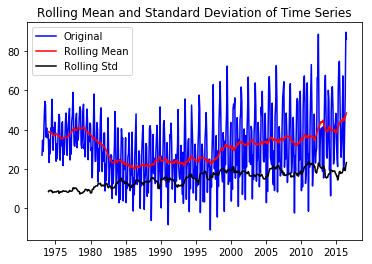

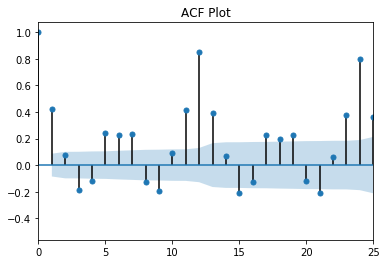

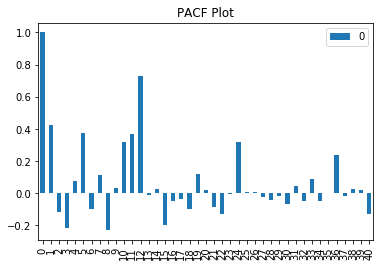

Results of Dickey-Fuller Test:
ADF Test Statistic              -0.182337
p-value                          0.940595
Number of Lags Used             18.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64


In [16]:
test_stationarity(ce.Shift_1.dropna(inplace=False))

The singly shifted data is much less stationary than the total electric data, although the other 2 types of shift produced simmilar results
Log shifted data seems to be the best in this case although still not a perfect fit

In [43]:
# Split into test and training data for model

# Split off just total energy
ce = data[data['Description']=='Coal Electric Power Sector CO2 Emissions']

# Split into training and test set
ce_train = ce[ce.index < '2010-01-01']
ce_test = ce[ce.index >= '2010-01-01']

In [22]:
# Do Gridsearch to find best arima parameters for raw data
arima_gridsearch(ce_train.Value.dropna(inplace=False),ce_test.Value.dropna(inplace=False), range(5),range(5),range(3))

ARIMA Parameters: (0, 0, 0)   Resulting MSE:545.4474734645554
ARIMA Parameters: (0, 0, 1)   Resulting MSE:521.3605998577478
ARIMA Parameters: (0, 1, 0)   Resulting MSE:2557.8948465303683
ARIMA Parameters: (0, 1, 1)   Resulting MSE:2982.1681004531556
ARIMA Parameters: (0, 1, 2)   Resulting MSE:2044.0579257425716
ARIMA Parameters: (0, 2, 0)   Resulting MSE:2118809.4956919933
ARIMA Parameters: (0, 2, 1)   Resulting MSE:2122.842939815478
ARIMA Parameters: (0, 2, 2)   Resulting MSE:2698.3770544408394
ARIMA Parameters: (1, 0, 0)   Resulting MSE:392.4649695513123
ARIMA Parameters: (1, 0, 1)   Resulting MSE:396.5403338549698
ARIMA Parameters: (1, 0, 2)   Resulting MSE:979.8391064760452
ARIMA Parameters: (1, 1, 0)   Resulting MSE:2885.425155681987
ARIMA Parameters: (1, 1, 1)   Resulting MSE:2352.491903292552
ARIMA Parameters: (1, 1, 2)   Resulting MSE:2264.8542429450454
ARIMA Parameters: (1, 2, 0)   Resulting MSE:1193646.5422311542
ARIMA Parameters: (2, 0, 0)   Resulting MSE:396.15166345317976


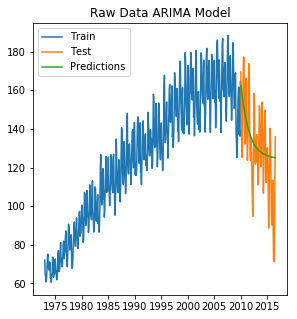

In [31]:
plot_predictions('Raw Data ARIMA Model',ce_train.Value,ce_test.Value,1,0,0)

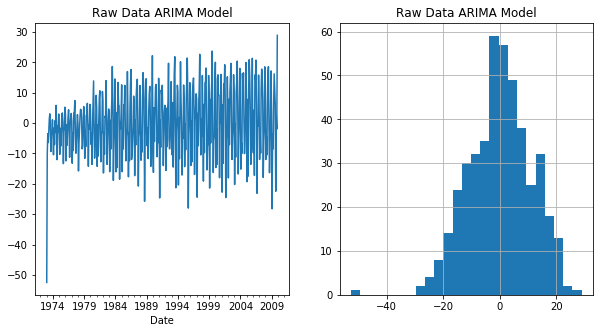

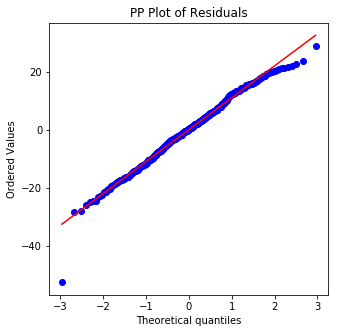

In [44]:
plot_model_residuals('Raw Data ARIMA Model',ce_train.Value,1,0,0)

Despite looking very simmilar to the total electric CO2 output, the model produced from the ARIMA model for the coal electric CO2 output seems to be a much better fit.  Although the models were not really able to capture the seasonal aspect of the data due to computational contraints, the overall trend created by the model is a fairly good fit, especially compared to the total electric CO2 model.  Next I will attempt to model the natural gas CO2 output.

# Model Building for Natural Gas CO2 Output

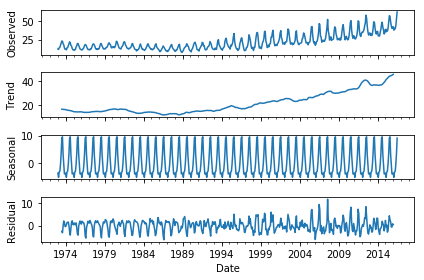

In [24]:
# Decompose data to show overall trend in data - data appears to be very seasonally dependent
decomp = seasonal_decompose(ng.Value,model='additive')
decomp.plot()
plt.show()

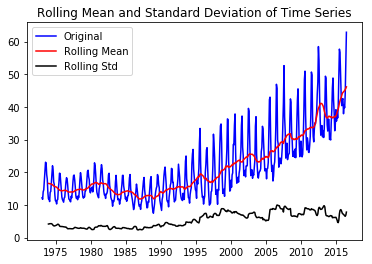

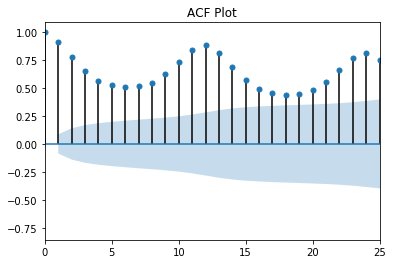

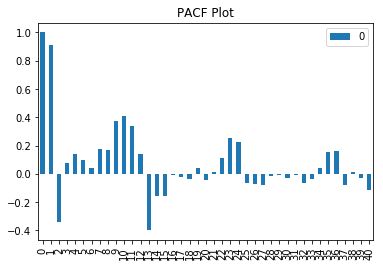

Results of Dickey-Fuller Test:
ADF Test Statistic               1.831215
p-value                          0.998409
Number of Lags Used             19.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64


In [25]:
# Test Stationarity of Natural Gas Electric CO2 Output
test_stationarity(ng.Value)

In [26]:
# Lets try shifting the data in a number of different ways to make data stationary
ng['Log_Difference'] = np.log(ng.Value).diff()
ng['Seasonal_Difference'] = ng.Value - ng.Value.shift(12)
ng['Shift_1'] = ng.Value - ng.Value.shift(1)

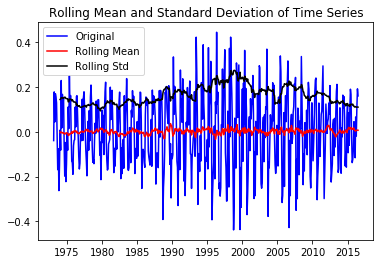

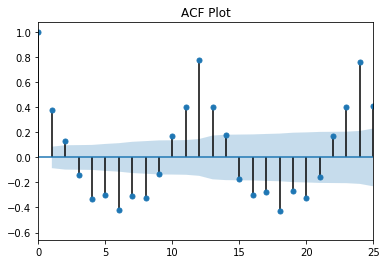

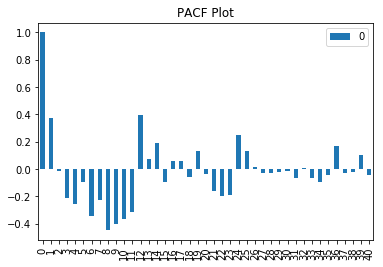

Results of Dickey-Fuller Test:
ADF Test Statistic              -4.964797
p-value                          0.000026
Number of Lags Used             18.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64


In [27]:
test_stationarity(ng.Log_Difference.dropna(inplace=False))

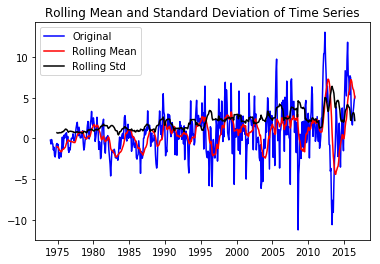

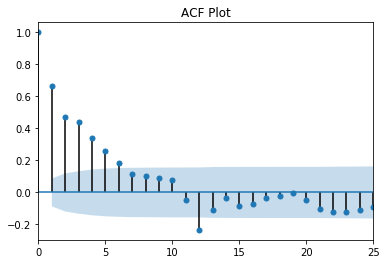

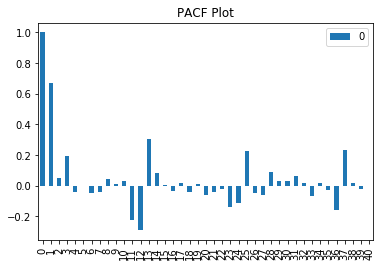

Results of Dickey-Fuller Test:
ADF Test Statistic              -4.412396
p-value                          0.000282
Number of Lags Used             13.000000
Number of Observations Used    497.000000
Critical Value (1%)             -3.443576
Critical Value (5%)             -2.867373
Critical Value (10%)            -2.569877
dtype: float64


In [29]:
test_stationarity(ng.Seasonal_Difference.dropna(inplace=False))

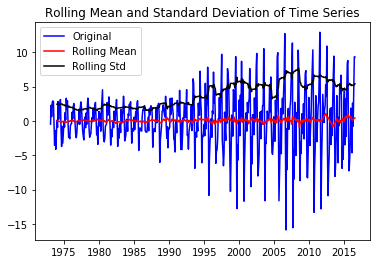

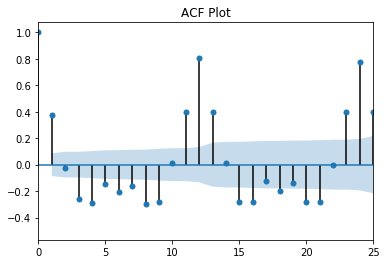

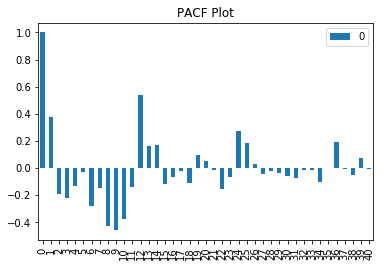

Results of Dickey-Fuller Test:
ADF Test Statistic              -5.435116
p-value                          0.000003
Number of Lags Used             18.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64


In [32]:
test_stationarity(ng.Shift_1.dropna(inplace=False))

In [45]:
# Split data into test and training sets
ng = data[data['Description']=='Natural Gas Electric Power Sector CO2 Emissions']
ng_train = ng[ng.index < '2010-01-01']
ng_test = ng[ng.index >= '2010-01-01']

In [34]:
# Do Gridsearch to find best arima parameters for raw data
arima_gridsearch(ng_train.Value.dropna(inplace=False),ng_test.Value.dropna(inplace=False), range(5),range(5),range(3))

ARIMA Parameters: (0, 0, 0)   Resulting MSE:470.22820835162133
ARIMA Parameters: (0, 0, 1)   Resulting MSE:468.58591975643344
ARIMA Parameters: (0, 1, 0)   Resulting MSE:146.94690966623796
ARIMA Parameters: (0, 1, 1)   Resulting MSE:120.94194670663352
ARIMA Parameters: (0, 1, 2)   Resulting MSE:107.6800653066385
ARIMA Parameters: (0, 2, 0)   Resulting MSE:25459.253598625957
ARIMA Parameters: (0, 2, 1)   Resulting MSE:127.73214087100226
ARIMA Parameters: (0, 2, 2)   Resulting MSE:96.32268411374814
ARIMA Parameters: (1, 0, 0)   Resulting MSE:446.91540047464673
ARIMA Parameters: (1, 0, 1)   Resulting MSE:454.96180900540537
ARIMA Parameters: (1, 0, 2)   Resulting MSE:459.380989502922
ARIMA Parameters: (1, 1, 0)   Resulting MSE:115.2651288893428
ARIMA Parameters: (1, 1, 1)   Resulting MSE:127.5512483144149
ARIMA Parameters: (1, 2, 0)   Resulting MSE:7305.002320441363
ARIMA Parameters: (2, 0, 0)   Resulting MSE:463.55734372216267
ARIMA Parameters: (2, 0, 1)   Resulting MSE:463.541399487604
A

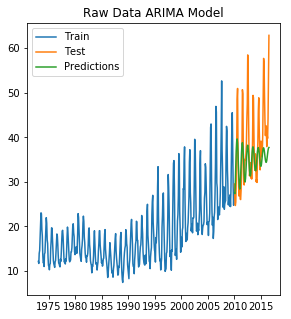

In [37]:
plot_predictions('Raw Data ARIMA Model',ng_train.Value,ng_test.Value,4,1,2)

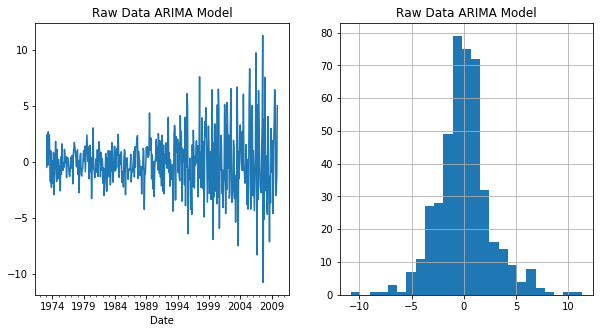

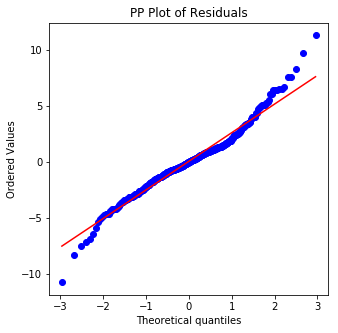

In [46]:
plot_model_residuals('Raw Data ARIMA Model',ng_train.Value,4,1,2)

This model produced fairly good results, and was somewhat able to incorporate the seasonal trends in the data although this model did a poor job of matching the full extent of the increase in the actual data, meaning that this model would most likely underrepresent future increases in natural gas if used to forecast future trends.  The last source I will try to model is the petroleum energy CO2 output

# Model Building for Petroleum Energy CO2 Output

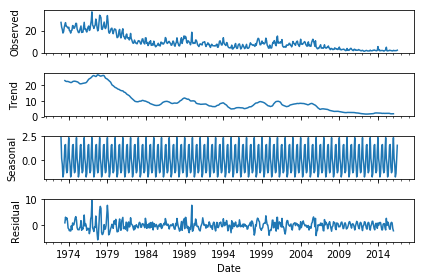

In [39]:
# Decompose data to show overall trend in data - much like other data appears to be very seasonally dependent
decomp = seasonal_decompose(pe.Value,model='additive')
decomp.plot()
plt.show()

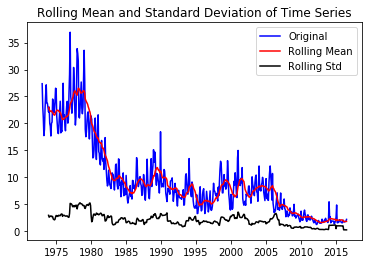

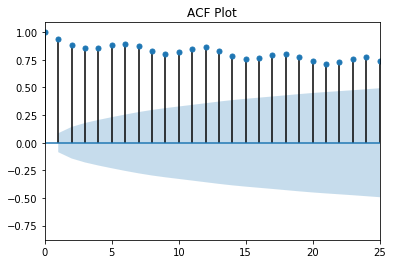

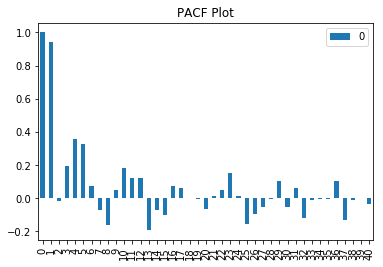

Results of Dickey-Fuller Test:
ADF Test Statistic              -1.577240
p-value                          0.495016
Number of Lags Used             14.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64


In [41]:
# Test Stationarity of Natural Gas Electric CO2 Output
test_stationarity(pe.Value)

In [47]:
# Split data into test and training set
pe = data[data['Description']=='Petroleum Electric Power Sector CO2 Emissions']
pe_train = pe[pe.index < '2010-01-01']
pe_test = pe[pe.index >= '2010-01-01']

In [43]:
# Do Gridsearch to find best arima parameters for raw data
arima_gridsearch(pe_train.Value.dropna(inplace=False),pe_test.Value.dropna(inplace=False), range(5),range(5),range(3))

ARIMA Parameters: (0, 0, 0)   Resulting MSE:78.11447454645621
ARIMA Parameters: (0, 0, 1)   Resulting MSE:77.8037876270745
ARIMA Parameters: (0, 1, 0)   Resulting MSE:6.978013005274698
ARIMA Parameters: (0, 1, 1)   Resulting MSE:6.981490958175063
ARIMA Parameters: (0, 1, 2)   Resulting MSE:4.069578223370236
ARIMA Parameters: (0, 2, 0)   Resulting MSE:963.4140451557336
ARIMA Parameters: (0, 2, 1)   Resulting MSE:0.5514105935735772
ARIMA Parameters: (0, 2, 2)   Resulting MSE:0.5713596799438049
ARIMA Parameters: (1, 0, 0)   Resulting MSE:58.32093482962543
ARIMA Parameters: (1, 0, 1)   Resulting MSE:61.83055608767042
ARIMA Parameters: (1, 0, 2)   Resulting MSE:3.1353695346299664
ARIMA Parameters: (1, 1, 0)   Resulting MSE:6.982016697689766
ARIMA Parameters: (1, 1, 1)   Resulting MSE:3.852832690409018
ARIMA Parameters: (1, 1, 2)   Resulting MSE:3.855685623585414
ARIMA Parameters: (1, 2, 0)   Resulting MSE:347.92595054606653
ARIMA Parameters: (2, 0, 0)   Resulting MSE:60.826432787385556
ARIM

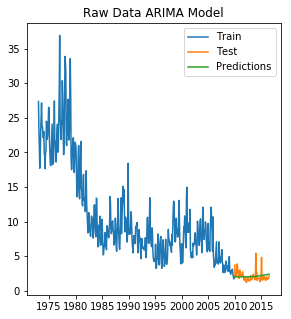

In [46]:
plot_predictions('Raw Data ARIMA Model',pe_train.Value,pe_test.Value,0,2,1)

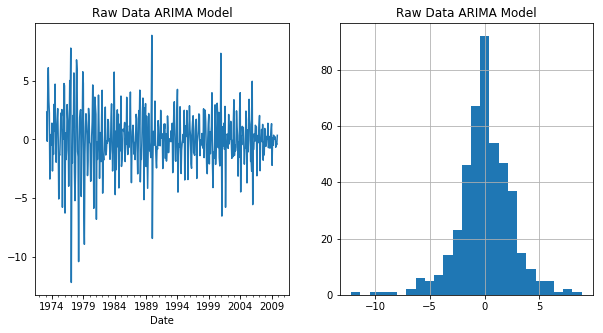

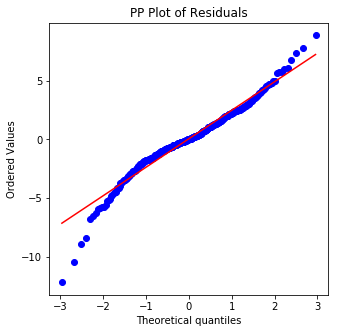

In [48]:
plot_model_residuals('Raw Data ARIMA Model',pe_train.Value,0,2,1)

This model produced very good results and was able to capture the trend in the data fairly well.  However, this is most likely simply due to the fact that petroleum energy CO2 output is slowly tapering off to 0 and thus is a fairly easy trend to match.

In [ ]:
Finally I decided to leave the total electric ARIMA gridsearch running for a number of days in order to try to incorporate the seasonality and produce a better fit for the total electric CO2 data

In [ ]:
# Run Gridsearch for total electric CO2 Output with more paramaters 
values_ = [0,1,2,3,4,12]

print('''
----------------------------------------------------------------------------------------------------
TOTAL ELECTRIC
----------------------------------------------------------------------------------------------------
''')
# Do Gridsesarch to find best ARIMA parameters for shifted data - Unsure if this is proper way to feed shifted data into model or not
arima_gridsearch(te_train.Value.dropna(inplace=False),te_test.Value.dropna(inplace=False),values_,values_,range(3))


----------------------------------------------------------------------------------------------------
TOTAL ELECTRIC
----------------------------------------------------------------------------------------------------

ARIMA Parameters: (0, 0, 0)   Resulting MSE:923.1188965168923
ARIMA Parameters: (0, 0, 1)   Resulting MSE:893.4768421403121
ARIMA Parameters: (0, 1, 0)   Resulting MSE:1817.454393223415
ARIMA Parameters: (0, 1, 1)   Resulting MSE:2280.7662881996616
ARIMA Parameters: (0, 1, 2)   Resulting MSE:2104.4163185948246
ARIMA Parameters: (0, 2, 0)   Resulting MSE:2714219.1283221478
ARIMA Parameters: (0, 2, 1)   Resulting MSE:1745.3196453149526
ARIMA Parameters: (0, 2, 2)   Resulting MSE:2448.6681511019133
ARIMA Parameters: (1, 0, 0)   Resulting MSE:727.0527522063767
ARIMA Parameters: (1, 0, 1)   Resulting MSE:763.4718293819994
ARIMA Parameters: (1, 0, 2)   Resulting MSE:920.969258032912
ARIMA Parameters: (1, 1, 0)   Resulting MSE:2198.5888945905713
ARIMA Parameters: (1, 1, 1)   Re

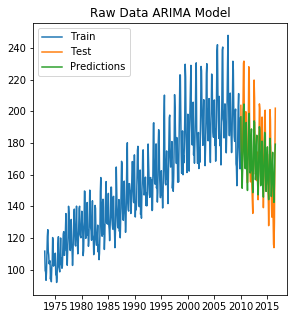

In [16]:
plot_predictions('Raw Data ARIMA Model',te_train.Value,te_test.Value,12,2,0)

This model was able to produce a much better fit for the data and was able to incorporate many of the trends present in the data, althouth it does still underrepresent the full extent with which the data spikes up and down.  However, compared to the original models created, this appears to be a much better model based on the overall look of the predicted data and the relatively low MSE value.  Unfortunately this model took nearly a day to produce on my machine, although this is promising, meaning that if more computational power was able to be used, I believe that the models created would drastically improve.

# Summary

The models produced by the data I aquired were suprisingly good given that this is very noisy data since it is representative of the entire US and is most likely influenced by a wide range of factors, and that the computational power at my disposal is fairly low.  However, based on these results, I believe that very accurate forecasts could be prepared using ARIMA modeling on this data if a more powerful machine was to be used, especially based on the results produced by the final total electric CO2 model.   All of the models produced throughout this experiment had relatively normal residuals (given the amount of noise present in the data) and were able to effectively match the trends in the data suprisingly well.  However, there is obviously still much work needed in order to use any of the information gained from this project to forecast future global climate changes.   If these models were able to be built on much more powerful machines, using global data instead of only using data from the US I believe the models produced would be able to very accurately predict the future changes in CO2 output, which could then in turn be used for regulatory and planning purposes.